<a href="https://colab.research.google.com/github/micheleintrevado/ML4MDE/blob/main/CodeCommentClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import nltk
nltk.download('stopwords')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)



Running on TPU  grpc://10.123.191.2:8470
Number of replicas: 8


In [3]:
# MODEL_NAME = 'roberta-base'
# MAX_LEN = 512
# ARTIFACTS_PATH = './artifacts/'

# BATCH_SIZE = 4 * strategy.num_replicas_in_sync
# EPOCHS = 10

# if not os.path.exists(ARTIFACTS_PATH):
#     os.makedirs(ARTIFACTS_PATH)

In [4]:
train_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/train.csv"
train_set = pd.read_csv(train_file_path)
train_set.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Data Preprocessing

In [5]:
train_set_prova = train_set.drop(columns=["TITLE", "ABSTRACT", "ID"])
train_set["category"] = train_set_prova.idxmax(axis=1).str.lower()
train_set.drop(columns=["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance", "ID"], inplace=True)
train_set.head()

,TITLE,ABSTRACT,category
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,computer science
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,computer science
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,mathematics
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,mathematics
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,computer science


# Joining the title and abstract into a single text column

In [6]:
train_set["text"] = train_set["TITLE"] + " " + train_set["ABSTRACT"]
train_set.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

In [7]:
X_data = train_set[['text']].to_numpy()
y_data = train_set[['category']].to_numpy()
print(f"len X_data: {len(X_data)}, len y_data: {len(y_data)}")

len X_data: 20972, len y_data: 20972


# Dataset Analysis

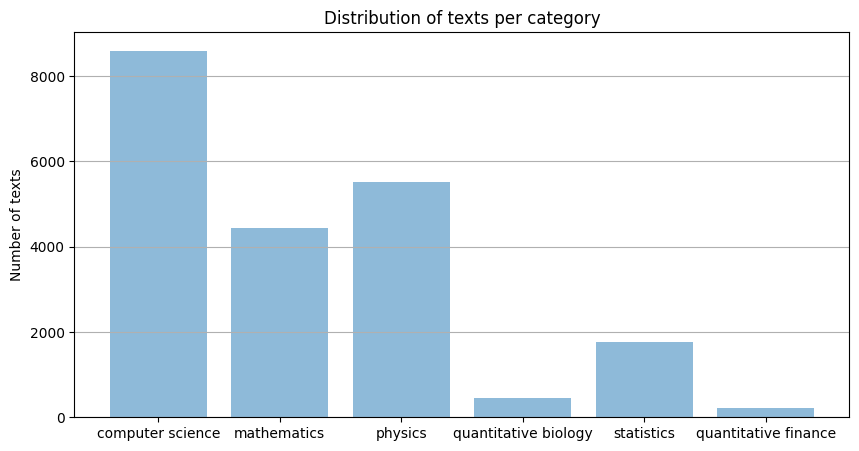

Counter({'computer science': 8594, 'physics': 5521, 'mathematics': 4436, 'statistics': 1765, 'quantitative biology': 447, 'quantitative finance': 209})


In [8]:
categories = train_set[['category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [9]:
def calculate_stats(df, split_char=' '):
    categories = df['category'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['category']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

def display_lengths_histograms(df_stats, n_cols=4):
    categories = train_set['category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 10))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [10]:
df_stats = calculate_stats(train_set)
df_stats['per_category']

,lengths,mean,stdev
computer science,"[270, 81, 146, 267, 143, 128, 142, 207, 119, 1...",169.130673,54.803028
mathematics,"[108, 120, 222, 57, 60, 159, 77, 164, 68, 109,...",115.883904,57.079053
physics,"[122, 133, 138, 224, 147, 144, 272, 286, 104, ...",172.434523,61.436704
quantitative biology,"[158, 238, 113, 202, 119, 146, 162, 275, 97, 1...",189.172260,59.060692
statistics,"[213, 188, 94, 177, 171, 150, 112, 167, 291, 1...",168.471388,54.872041
quantitative finance,"[109, 149, 148, 146, 91, 110, 36, 133, 174, 16...",150.119617,55.745042


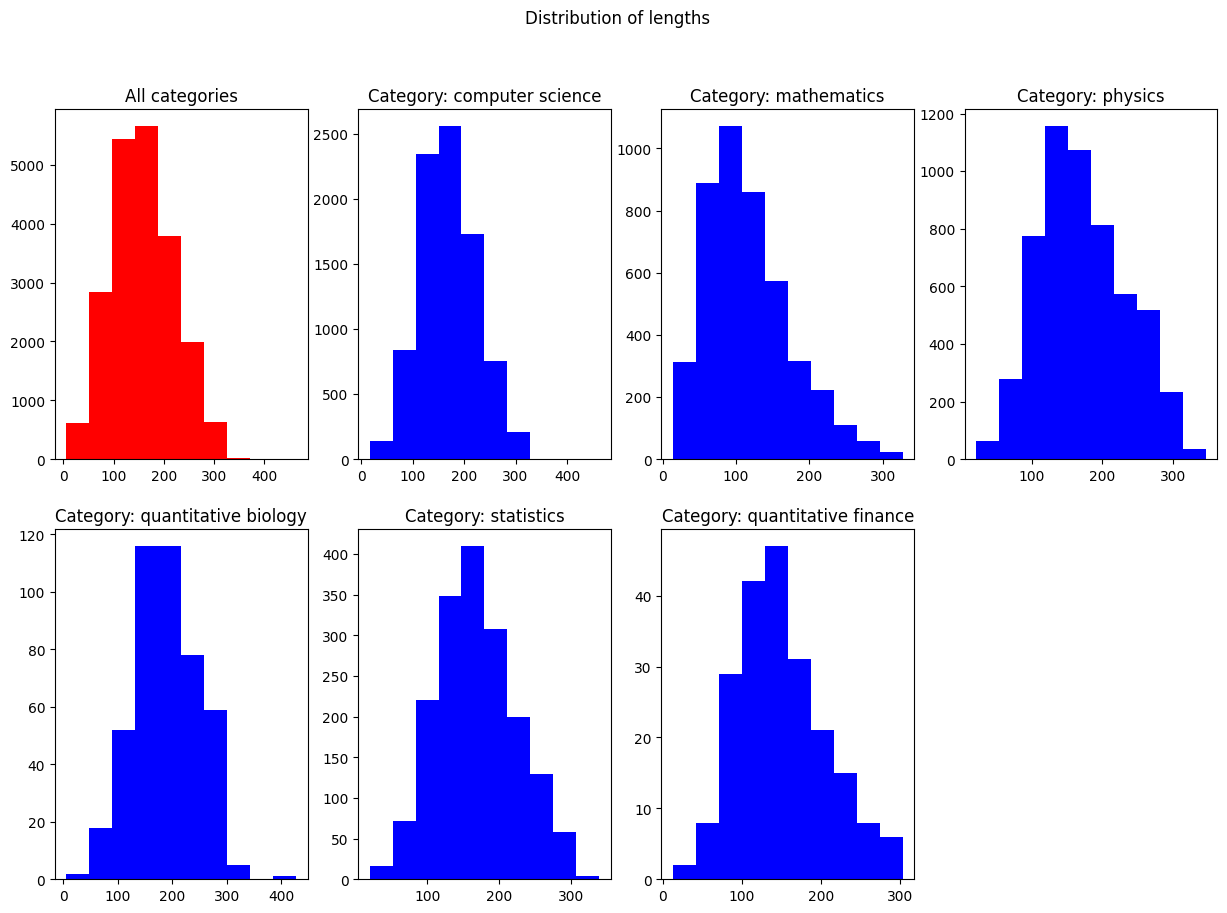

In [11]:
display_lengths_histograms(df_stats)

In [12]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = train_set['category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

Texts in dataset: 20972
Number of categories: 6


# Tokenization

In [13]:
# def roberta_encode(texts, tokenizer):
#     ct = len(texts)
#     input_ids = np.ones((ct, MAX_LEN), dtype='int32')
#     attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
#     token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

#     for k, text in enumerate(texts):
#         # Tokenize
#         tok_text = tokenizer.tokenize(text)

#         # Truncate and convert tokens to numerical IDs
#         enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

#         input_length = len(enc_text) + 2
#         input_length = input_length if input_length < MAX_LEN else MAX_LEN

#         # Add tokens [CLS] and [SEP] at the beginning and the end
#         input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

#         # Set to 1s in the attention input
#         attention_mask[k,:input_length] = 1

#     return {
#         'input_word_ids': input_ids,
#         'input_mask': attention_mask,
#         'input_type_ids': token_type_ids
#     }

In [14]:
# # Transform categories into numbers
# category_to_id = {}
# category_to_name = {}

# for index, c in enumerate(y_data):
#     if c[0] in category_to_id:
#         category_id = category_to_id[c[0]]
#     else:
#         category_id = len(category_to_id)
#         category_to_id[c[0]] = category_id
#         category_to_name[category_id] = c[0]

#     y_data[index] = category_id

# # Display dictionary
# category_to_name

In [15]:
# y_data

In [16]:
# X_data = X_data.flatten()
# y_data = y_data.flatten()

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [18]:
# # Import tokenizer from HuggingFace
# tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [19]:
# X_train = roberta_encode(X_train, tokenizer)
# X_test = roberta_encode(X_test, tokenizer)


# y_train = np.asarray(y_train, dtype='int32')
# y_test = np.asarray(y_test, dtype='int32')

# Prova model

In [20]:
train_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/train.csv"
train_set = pd.read_csv(train_file_path)
train_set.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [21]:
train_set_prova = train_set.drop(columns=["TITLE", "ABSTRACT", "ID"])
train_set["category"] = train_set_prova.idxmax(axis=1).str.lower()
train_set.drop(columns=["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance", "ID"], inplace=True)
train_set.head()

,TITLE,ABSTRACT,category
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,computer science
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,computer science
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,mathematics
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,mathematics
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,computer science


In [22]:
train_set["text"] = train_set["TITLE"] + " " + train_set["ABSTRACT"]
train_set.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

In [23]:
X_data = train_set[['text']].to_numpy()
y_data = train_set[['category']].to_numpy()
print(f"len X_data: {len(X_data)}, len y_data: {len(y_data)}")

len X_data: 20972, len y_data: 20972


In [24]:
contractions_dict = {
    "don't": "do not",
    "doesn't": "does not",
    "can't": "cannot",
    "isn't": "is not",
    "won't": "will not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "I won't": "I will not",
    "you won't": "you will not",
    "he won't": "he will not",
    "she won't": "she will not",
    "we won't": "we will not",
    "they won't": "they will not",
}

In [25]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [26]:
def prepare_text(text: str):
    text = text.lower()
    text = text.replace('"', '')
    text = " ".join([contractions_dict.get(word, word) for word in text.split()])
    text = re.sub("[^a-zA-Z]", " ", text)
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    return " ".join(words).strip()

In [27]:
train_set['text'] = train_set['text'].apply(prepare_text)
train_set

,category,text
0,computer science,reconstructing subject specific effect maps pr...
1,computer science,rotation invariance neural network rotation in...
2,mathematics,spherical polyharmonics poisson kernels polyha...
3,mathematics,finite element approximation stochastic maxwel...
4,computer science,comparative study discrete wavelet transforms ...
...,...,...
20967,computer science,contemporary machine learning guide practition...
20968,physics,uniform diamond coatings wc co hard alloy cutt...
20969,computer science,analysing soccer games clustering conceptors p...
20970,mathematics,efficient simulation left tail sum correlated ...


In [28]:
# test_file_path = r"https://raw.githubusercontent.com/micheleintrevado/ML4MDE/main/archive/test.csv"
# test_set = pd.read_csv(train_file_path)
# test_set.head()

In [29]:
# test_set_prova = test_set.drop(columns=["TITLE", "ABSTRACT", "ID"])
# test_set["category"] = test_set_prova.idxmax(axis=1).str.lower()
# test_set.drop(columns=["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance", "ID"], inplace=True)
# test_set.head()

In [30]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c[0] in category_to_id:
        category_id = category_to_id[c[0]]
    else:
        category_id = len(category_to_id)
        category_to_id[c[0]] = category_id
        category_to_name[category_id] = c[0]

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'computer science',
 1: 'mathematics',
 2: 'physics',
 3: 'quantitative biology',
 4: 'statistics',
 5: 'quantitative finance'}

In [31]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import concatenate
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
  print("Lines: ", lines)
  return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

# define the model
def define_model(length, vocab_size):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 3
  inputs3 = Input(shape=(length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # channel 4
  inputs4 = Input(shape=(length,))
  embedding4 = Embedding(vocab_size, 100)(inputs4)
  conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(embedding4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling1D(pool_size=2)(drop4)
  flat4 = Flatten()(pool4)
  # merge
  merged = concatenate([flat1, flat2, flat3, flat4])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)

  # Add a dropout layer before the last output layer
  last_drop = Dropout(0.5)(dense1)

  outputs = Dense(6, activation='softmax')(last_drop)
  model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)
  opt = tf.keras.optimizers.SGD()
  # compile
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'], )
  # summarize
  print(model.summary())
  plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

# load training dataset
trainLines, testLines, trainLabels, testLabels = train_test_split(X_data.flatten(), y_data, test_size=0.2, random_state=42)
# X_data.flatten(), y_data

# create tokenizer
tokenizer = create_tokenizer(trainLines)

# calculate max document length
length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
print('TRAIN X: ', trainX)
print(trainX.shape)

trainX = np.asarray(trainX).astype('float32')
trainLabels = np.asarray(trainLabels).astype('float32')

# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX,trainX], array(trainLabels), epochs=10, batch_size=8)

Lines:  ['Reverse Quantum Annealing Approach to Portfolio Optimization Problems   We investigate a hybrid quantum-classical solution method to the\nmean-variance portfolio optimization problems. Starting from real financial\ndata statistics and following the principles of the Modern Portfolio Theory, we\ngenerate parametrized samples of portfolio optimization problems that can be\nrelated to quadratic binary optimization forms programmable in the analog\nD-Wave Quantum Annealer 2000Q. The instances are also solvable by an\nindustry-established Genetic Algorithm approach, which we use as a classical\nbenchmark. We investigate several options to run the quantum computation\noptimally, ultimately discovering that the best results in terms of expected\ntime-to-solution as a function of number of variables for the hardest instances\nset are obtained by seeding the quantum annealer with a solution candidate\nfound by a greedy local search and then performing a reverse annealing\nprotocol. Th

Evaluate model

In [32]:
# encode data
testX = encode_text(tokenizer, testLines, length)

testX = np.asarray(testX).astype('float32')
testLabels = np.asarray(testLabels).astype('float32')

# evaluate model on training dataset
loss, acc = model.evaluate([trainX,trainX,trainX,trainX], array(trainLabels), verbose=0)
print('Train Accuracy: %f' % (acc*100))

# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX,testX,testX],array(testLabels), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 81.593847
Test Accuracy: 78.116804


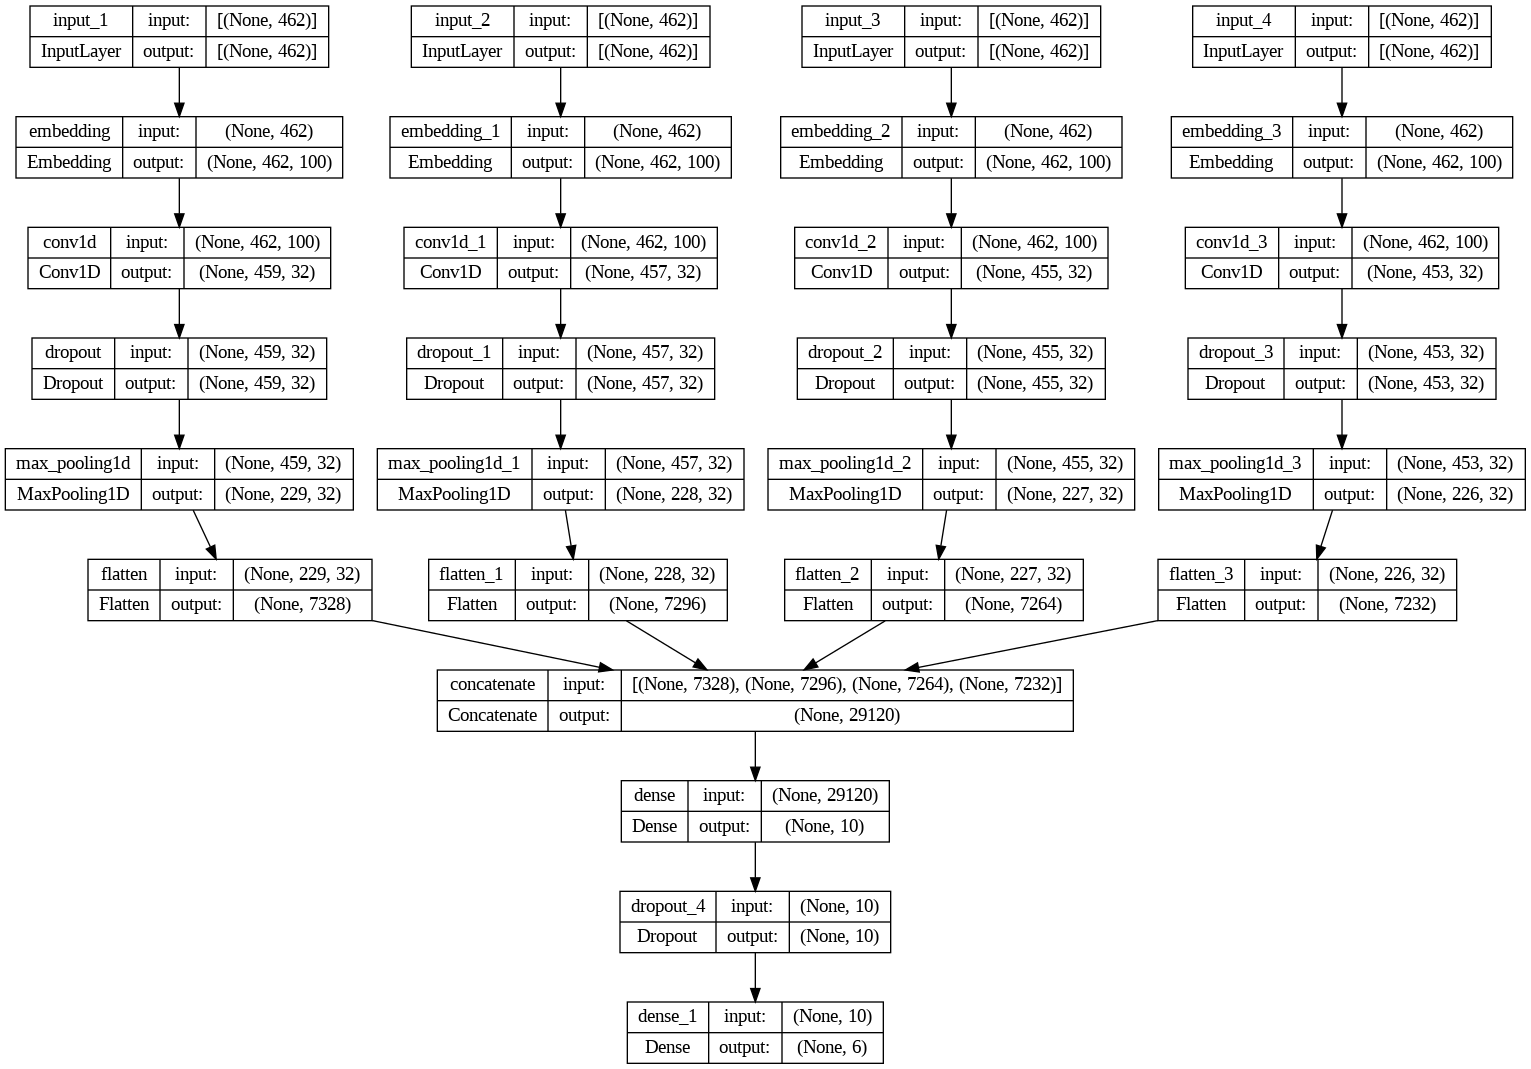

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True)